In [15]:
from pathlib import Path

from typing import Any, Literal, Annotated
from collections.abc import Sequence
from torch.types import Device
from numpy.typing import NDArray

from pandas import DataFrame

import pandas as pd

from gymnasium.vector import AsyncVectorEnv

from dataclasses import dataclass

import json
import numpy as np

import torch
import torch.nn as nn

from torch.optim import Adam

from gymnasium import Env, make_vec

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from matplotlib.colors import to_rgba

sns.set_style('whitegrid')
sns.set_palette("Set2")

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from cpscheduler.environment.metrics import ReferenceScheduleMetrics
from cpscheduler.gym import SchedulingEnvGym, PermutationActionWrapper, InstancePoolWrapper, ArrayObservationWrapper
from cpscheduler import SingleMachineSetup, WeightedTardiness, TotalTardiness, Objective

from cpscheduler.heuristics._pdr import PriorityDispatchingRule, CostOverTime, WeightedShortestProcessingTime, ModifiedDueDate, ApparentTardinessCost

from cpscheduler.rl.policies import PlackettLucePolicy

import cpscheduler.rl as rl
from cpscheduler.rl.evaluation import confidence_interval

INSTANCE_PATH = Path("data/customers/wt40_50_0.5.pkl")
DATASET_PATH = Path("data/customers/wt40_50_0.5_dataset.pkl")

features = ["processing_time", "due_date", "customer"]

device = rl.utils.get_device()

rl.set_seed(0)

def load_tensorboard_data(logdir: str | Path) -> pd.DataFrame:
    acc = EventAccumulator(str(logdir))
    acc.Reload()

    tags = acc.Tags()['scalars']

    df = pd.DataFrame()

    for tag in tags:
        events = acc.Scalars(tag)

        df_tag = pd.DataFrame(events)

        df_tag.drop(columns=['wall_time'], inplace=True)
        df_tag.rename(columns={'value': tag}, inplace=True)
        df_tag.set_index('step', inplace=True)

        df = df.join(df_tag, how='outer')

    return df

pdrs = ["WSPT", "WMDD", "COverT", "ATC"]

color_palette = sns.color_palette("tab10")
colors = {
    "WSPT": color_palette[1],
    "WMDD": color_palette[3],
    "COverT": color_palette[4],
    "ATC": color_palette[5],
}


In [ ]:
df_lst: list[DataFrame] = []

weights = {pdr: [] for pdr in pdrs}


for pdr in pdrs:
    paths = list(Path(f"logs/parameter_random/{pdr}").glob("*/"))

    for path in paths:
        with open(path / "config.json", "r") as f:
            config = json.load(f)

        df = load_tensorboard_data(path)
        df["PDR"] = pdr

        df_lst.append(df)

        policy = torch.load(path / "policy.pkl", map_location="cpu", weights_only=False)

        weights[pdr].append(policy.score_model.weights.detach().numpy())

In [21]:
pretrained_dfs = {}

for path in Path(f"logs/parameter/").glob("*/"):
    with open(path / "config.json", "r") as f:
        config = json.load(f)
    
    df = load_tensorboard_data(path)
    pretrained_dfs[config["pdr"]] = df

    df["PDR"] = config["pdr"]
    df_lst.append(df)

    policy = torch.load(path / "policy.pkl", map_location="cpu", weights_only=False)

    weights[pdr].append(policy.score_model.weights.detach().numpy())


results = pd.concat(df_lst).reset_index(drop=False)

[2025-08-17 18:10:19,196] [tensorboard] [directory_watcher.py(123)] [INFO] No path found after logs/parameter/2025-08-17_03-22-05_7f22/events.out.tfevents.1755400925.dl-03.3952787.0
[2025-08-17 18:10:19,825] [tensorboard] [directory_watcher.py(123)] [INFO] No path found after logs/parameter/2025-08-17_03-22-05_8625/events.out.tfevents.1755400925.dl-03.3952786.0
[2025-08-17 18:10:20,449] [tensorboard] [directory_watcher.py(123)] [INFO] No path found after logs/parameter/2025-08-17_03-22-05_7f73/events.out.tfevents.1755400925.dl-03.3952785.0
[2025-08-17 18:10:21,072] [tensorboard] [directory_watcher.py(123)] [INFO] No path found after logs/parameter/2025-08-17_03-22-05_337c/events.out.tfevents.1755400925.dl-03.3952784.0


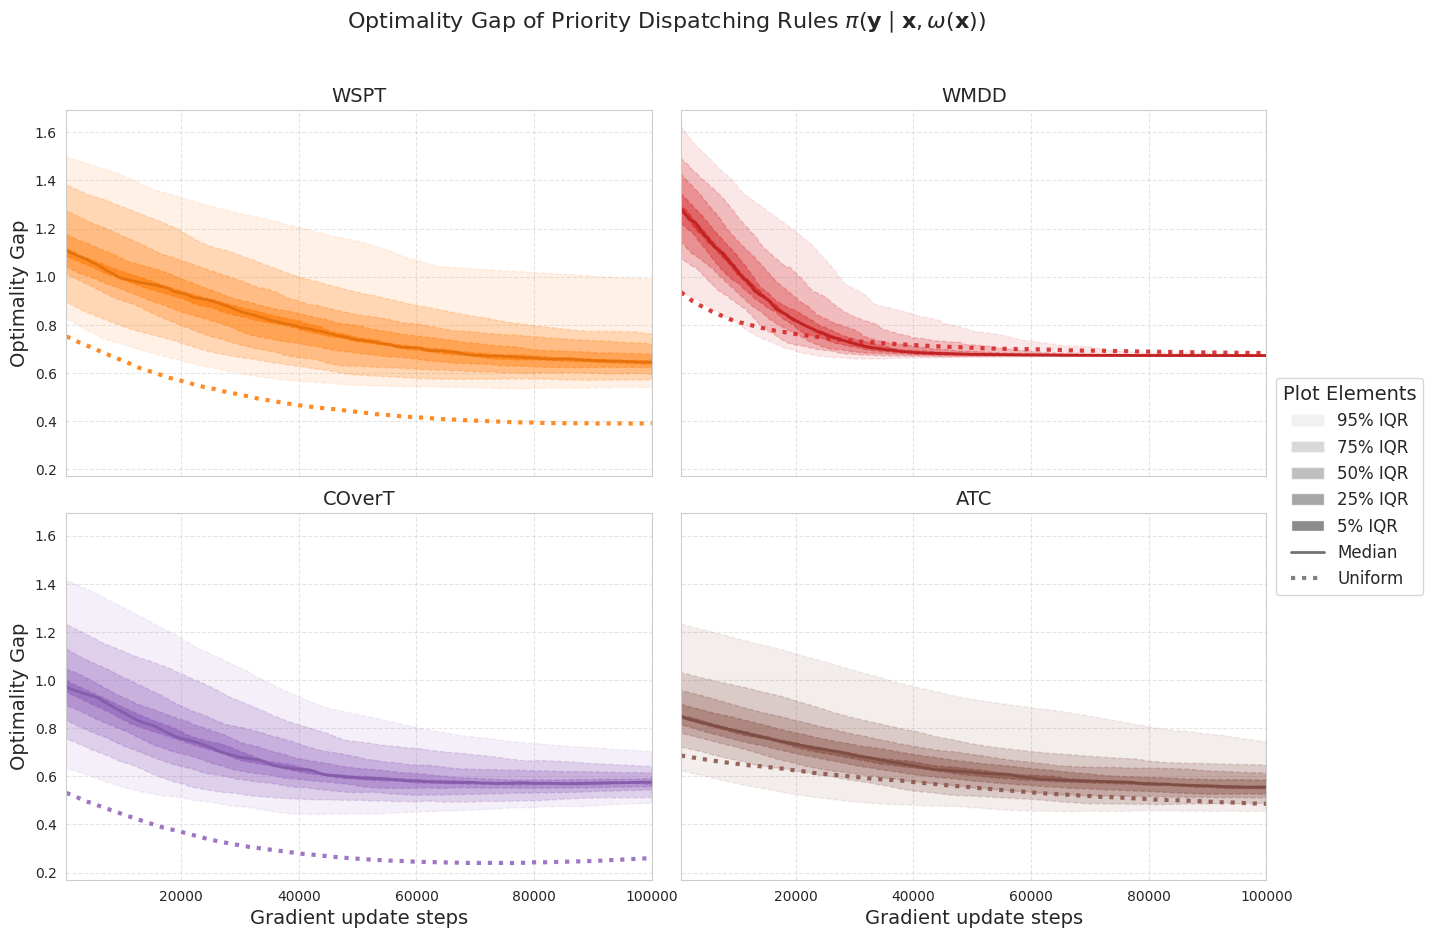

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.05, hspace=0.1, left=0.1, right=0.9)

axs = axs.flatten()

ymin, ymax = np.inf, -np.inf  # auto y-limits


quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
initial_alpha = 0.1
final_alpha = 0.9

cumulative = np.linspace(initial_alpha, final_alpha, len(quantiles))
alphas = np.zeros_like(cumulative)

alphas[0] = initial_alpha
for i in range(1, len(quantiles)):
    alphas[i] = 1 - (1 - cumulative[i]) / (1 - cumulative[i-1])

for i, pdr in enumerate(pdrs):
    color = colors[pdr]

    pdr_results = results[results["PDR"] == pdr]
    steps = pdr_results.groupby("step")["step"].first().to_numpy()
    array = np.stack(pdr_results.groupby("step")['val/optimal_gap'].apply(np.array).to_list())
    
    mean_curve = np.median(array, axis=-1)
    dark_color = tuple(max(c*0.9, 0) for c in color[:3])  # darken by 30%
    axs[i].plot(steps, mean_curve, color=dark_color, linewidth=2)

    for alpha, q in zip(alphas, quantiles):
        lower = np.quantile(array, q/2, axis=1)
        upper = np.quantile(array, 1-q/2, axis=1)
        axs[i].fill_between(steps, lower, upper, color=color, alpha=alpha, linestyle="--")

        ymin = min(ymin, lower.min())
        ymax = max(ymax, upper.max())

    y = pretrained_dfs[pdr]['val/optimal_gap']

    axs[i].plot(
        steps,
        y,
        color=color,
        alpha=0.9,
        linewidth=3,
        linestyle=':',
        zorder=1
    )

    ymin = min(ymin, y.min())
    ymax = max(ymax, y.max())

    # axs[i].plot(
    #     steps,
    #     pretrained_dfs['ATC']['val/optimal_gap'],
    #     color=dark_color,
    #     linewidth=1,
    #     zorder=2
    # )

    axs[i].grid(True, linestyle='--', alpha=0.5)
    axs[i].set_title(f"{pdr}", fontsize=14)


axs[2].set_xlabel("Gradient update steps", fontsize=14)
axs[3].set_xlabel("Gradient update steps", fontsize=14)

axs[0].set_ylabel("Optimality Gap", fontsize=14)
axs[2].set_ylabel("Optimality Gap", fontsize=14)


# shared labels
fig.suptitle("Optimality Gap of Priority Dispatching Rules $\\pi(\\mathbf{y}\\mid \\mathbf{x}, \\omega(\\mathbf{x}))$", fontsize=16)

# set consistent y-limits
y_margin = 0.05 * (ymax - ymin)
for ax in axs:
    ax.set_ylim(ymin - y_margin, ymax + y_margin)
    ax.set_xlim(steps[0], steps[-1])

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

gray_color = (0.5, 0.5, 0.5)
dark_gray = (0.45, 0.45, 0.45)
legend_handles = []
legend_labels = []


for i in range(len(quantiles)-1, -1, -1):
    q = quantiles[i]
    alpha = cumulative[-1-i]
    legend_handles.append(Patch(facecolor=gray_color, alpha=alpha))
    legend_labels.append(f"{q:>.0%} IQR")

legend_handles.append(Line2D([0], [0], color=dark_gray, linewidth=2))
legend_labels.append("Median")

legend_handles.append(Line2D([0], [0], color=dark_gray, linewidth=3, linestyle=':', alpha=0.9))
legend_labels.append("Uniform")

fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    title="Plot Elements",
    bbox_to_anchor=(1.01, 0.62),
    loc='upper right',
    fontsize=12,
    title_fontsize=14,
    ncol=1,
    frameon=True
)

plt.savefig("notebooks/figures/parameter_estimation_pdrs.pdf", bbox_inches='tight', dpi=300)

plt.show()

## Bias-Variance tradeoff

Report MSE, and decompose it into bias and variance


In [22]:
list_instances: list[DataFrame]
instance_info: DataFrame
customer_information: DataFrame

list_instances, instance_info, customer_information = pd.read_pickle(INSTANCE_PATH)
train_dataset: list[DataFrame] = pd.read_pickle(DATASET_PATH)

behavior_performance = instance_info["behavior"].to_numpy()
optimal_performance = instance_info["optimal"].to_numpy()
thresholds = np.linspace(0, 1, num=100)

optimal_action = np.load("data/customers/optimal_actions.npy")

true_weights = customer_information["weight"].to_numpy()
original_weights = customer_information["weight_original"].to_numpy()

In [27]:
for pdr in pdrs:
    weights[pdr] = np.stack(weights[pdr])

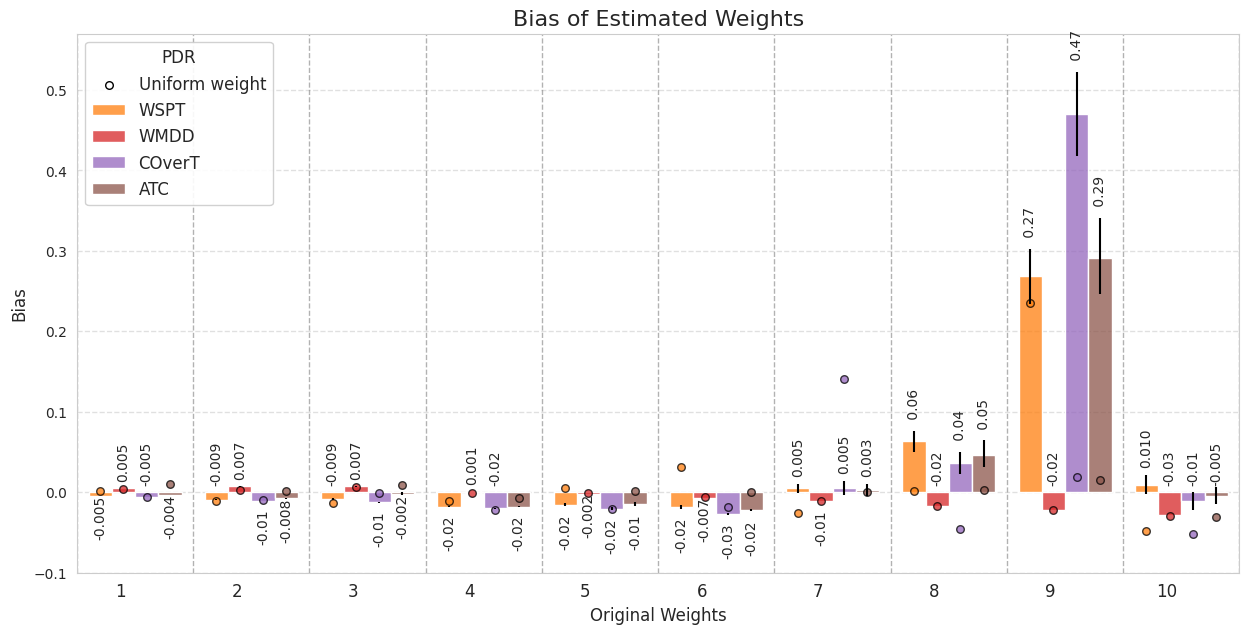

In [285]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.set_xlabel("Original Weights", fontsize=12)
ax.set_ylabel("Bias", fontsize=12)

ax.set_title("Bias of Estimated Weights", fontsize=16)
ax.set_xticks(np.arange(1, 11) + 0.25 * (len(pdrs) - 1) / 2)
ax.set_xticklabels(np.arange(1, 11), fontsize=12)
# ax.set_yscale("log")

ax.grid(False)

# set y grid
ax.yaxis.grid(True, linestyle="--", linewidth=1, alpha=0.6)

ax.set_xlim(1, 11)

for x in range(1, 12):
    ax.axvline(x, color="grey", linestyle="--", linewidth=1, alpha=0.6)

for i, pdr in enumerate(pdrs, start=1):
    w = weights[pdr]


    residuals = w - true_weights
    for original_weight in range(1, 11):
        group_residuals = residuals[:, original_weights == original_weight].reshape(-1)
        x = original_weight + i/5

        biases, lower, upper = confidence_interval(
            group_residuals,
            n_bootstrap=1000,
            confidence=0.95,
        )

        bias = np.mean(biases)

        bar = ax.bar(
            x,
            bias,
            width=0.2,
            label=pdr if original_weight == 1 else None,
            color=to_rgba(colors[pdr], alpha=0.75),
            yerr=[[bias - lower], [upper - bias]],
        )

        uniform_residual = group_residuals[-1]

        gap = 0.009

        if bias < 0:
            y = lower - 6*gap

            if abs(y - uniform_residual) < 6* gap:
                y = gap

        else:
            y = upper + gap

        ax.text(
            x,
            y,
            f"{bias:>5.2f}" if abs(bias) >= 0.01 else f"{bias:>4.3f}",
            ha='center',
            va='bottom',  # text above y
            fontsize=10,
            rotation=90
        )
        ax.scatter(
            x,
            uniform_residual,
            color=colors[pdr],
            alpha=0.75,
            # label=pdr if original_weight == 1 else None,
            s=30,
            edgecolor="black",
            linewidth=1
        )

ax.set_ylim(-0.1, 0.57)
plt.scatter([], [], color="white", s=30, edgecolor="black", linewidth=1, label="Uniform weight")

plt.legend(
    title="PDR",
    loc="upper left",
    fontsize=12,
    title_fontsize=12,
    frameon=True,
    framealpha=0.9
)

# add a dot to the legend

plt.savefig("notebooks/figures/parameter_bias.pdf", bbox_inches='tight', dpi=300)
plt.show()

---

In [12]:
weights = {pdr: {} for pdr in pdrs}


for pdr in pdrs:
    paths = list(Path(f"logs/parameter_ablation/{pdr}").glob("*/"))

    for path in paths:
        with open(path / "config.json", "r") as f:
            config = json.load(f)

        policy = torch.load(path / "policy.pkl", map_location="cpu", weights_only=False)
        weights[pdr][config["frac_train"]] = policy.score_model.weights.detach().numpy()

In [3]:
for pdr in pdrs:
    weights[pdr] = np.stack(weights[pdr])

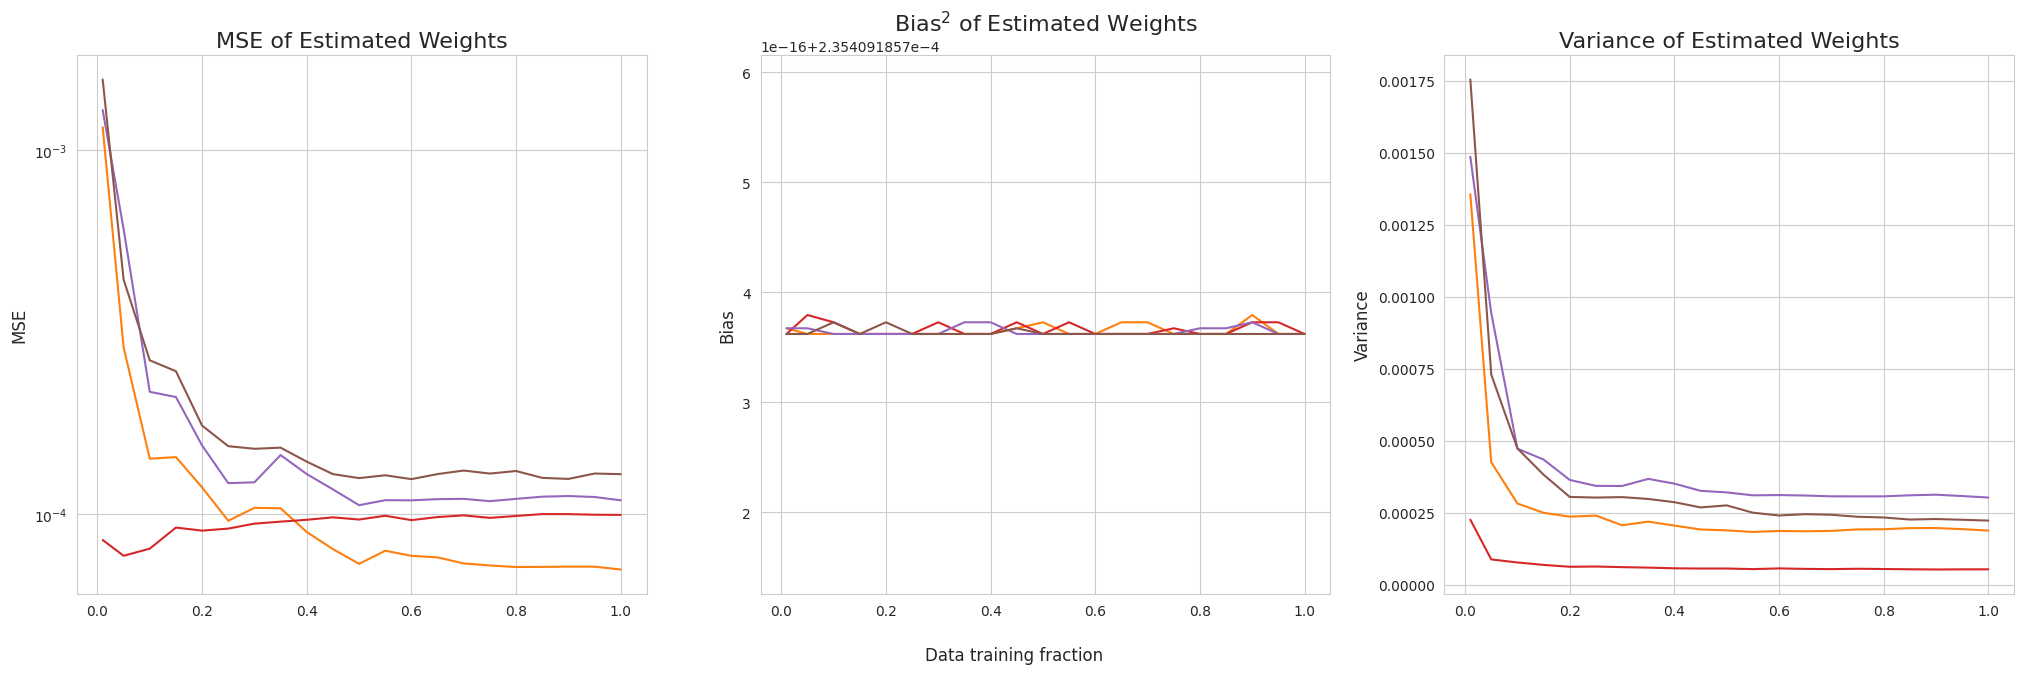

In [35]:
fig, axs = plt.subplots(ncols=3, figsize=(25, 7))

fig.supxlabel("Data training fraction", fontsize=12)
axs[0].set_ylabel("MSE", fontsize=12)
axs[1].set_ylabel("Bias", fontsize=12)
axs[2].set_ylabel("Variance", fontsize=12)

axs[0].set_title("MSE of Estimated Weights", fontsize=16)
axs[1].set_title("Bias$^2$ of Estimated Weights", fontsize=16)
axs[2].set_title("Variance of Estimated Weights", fontsize=16)


axs[0].set_yscale("log")

fracs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
for i, pdr in enumerate(pdrs):
    color = colors[pdr]

    mses = [
        np.mean((weights[pdr][frac] - true_weights) ** 2) for frac in fracs
    ]

    bias = [
       np.mean((np.mean(weights[pdr][frac]) - true_weights) ** 2) for frac in fracs
    ]

    variance = [
        np.mean((weights[pdr][frac] - np.mean(weights[pdr][frac])) ** 2) for frac in fracs
    ]

    axs[0].plot(
        fracs, mses, label=pdr, color=color
    )

    axs[1].plot(
        fracs, bias, label=pdr, color=color
    )

    axs[2].plot(
        fracs, variance, label=pdr, color=color
    )
